In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import pickle
%matplotlib inline

In [2]:
# Read in our vehicles and non-vehicles
car_images = glob.glob('vehicles/*/*.png')
notcar_images = glob.glob('non-vehicles/*/*.png')
cars = []
notcars = []
for car in car_images:
    cars.append(car)
    
for notcar in notcar_images:
    notcars.append(notcar)

In [3]:
def convert_png_2_jpg(img):    
    imag = img * 255
    image = imag.astype(np.uint8)
    return image

In [4]:
color_space = 'YCrCb' # RGB, HSV, LUV, HLS, YUV or YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [350, 656] # Min and max in y to search in slide_window()
transform_sqrt = True # Was True
xy_window = (64, 64)
threshold = 4.0
scale = 1.0
maxlen = 15

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=transform_sqrt, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=transform_sqrt, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [7]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [8]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, bins_range=(0,256) ):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        image = mpimg.imread(file)
        if image.dtype == 'float32':
            image = convert_png_2_jpg(image)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)    

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=bins_range)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [9]:
t = time.time()
car_features = extract_features(cars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size, 
                        spatial_feat=spatial_feat, hog_feat=hog_feat, hist_feat=hist_feat,
                        hist_bins=hist_bins)
notcar_features = extract_features(notcars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size, 
                        spatial_feat=spatial_feat, hog_feat=hog_feat, hist_feat=hist_feat,
                        hist_bins=hist_bins)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
print(scaled_X.shape)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print('y_train:', len(y_train))
print('y_test:', len(y_test))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

C:\Anaconda3\envs\CarND-Vehicle-Detection\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


112.53 Seconds to extract features...
(17760, 8460)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
y_train: 14208
y_test: 3552
7.27 Seconds to train SVC...
Test Accuracy of SVC =  0.9921
My SVC predicts:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
0.001 Seconds to predict 10 labels with SVC


# Save X_scaler and svc for later use

In [10]:
dist_pickle = {}
dist_pickle["X_scaler"] = X_scaler
dist_pickle["svc"] = svc

pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

In [11]:
import pickle
dist_pickle_load = pickle.load(open("wide_dist_pickle.p", 'rb'))
X_scaler = dist_pickle_load["X_scaler"]
svc = dist_pickle_load["svc"]
#print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    win_list = []
    img_tosearch = img[ystart:ystop,:,:]
    #global color_space
    if color_space != 'RGB':
        if color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    else: ctrans_tosearch = np.copy(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, 
                                     (np.int(imshape[1]/scale), 
                                      np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    #nx_blocks = (ch1.shape[1] // pix_per_cell) - 1
    #ny_blocks = (ch1.shape[0] // pix_per_cell) - 1
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, 
                             xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, 
                             xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, 
                             xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, 
                                                          hist_features, 
                                                          hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                win_list.append(((xbox_left, ytop_draw+ystart), 
                                 (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart), 
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return win_list, draw_img

In [13]:
def process_image_no_heatmap(image):
    draw_image = np.copy(image)
    win_list, out_img = find_cars(image, y_start_stop[0], y_start_stop[1], 1.0, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, 
                        spatial_size, hist_bins)
    return win_list, out_img

C:\Anaconda3\envs\CarND-Vehicle-Detection\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


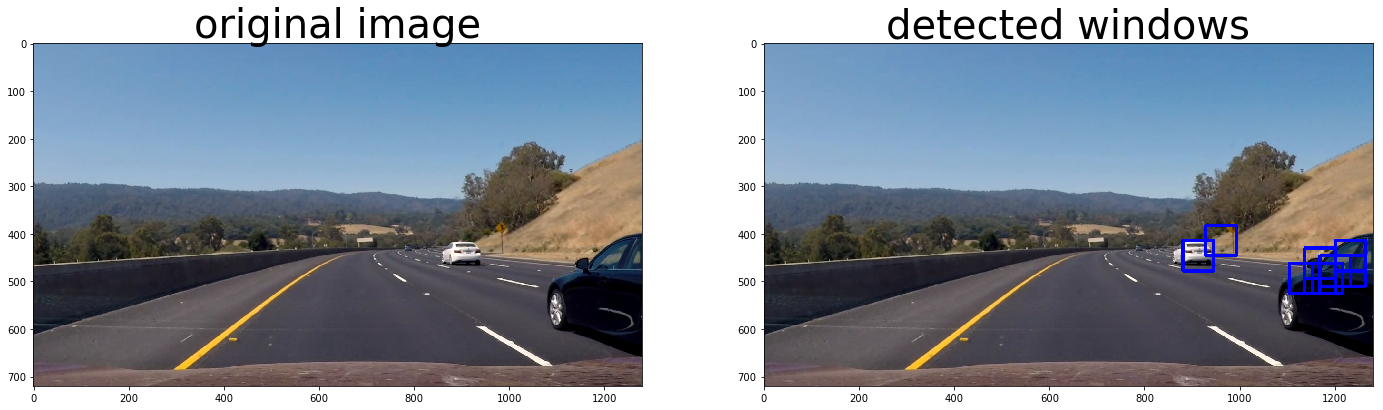

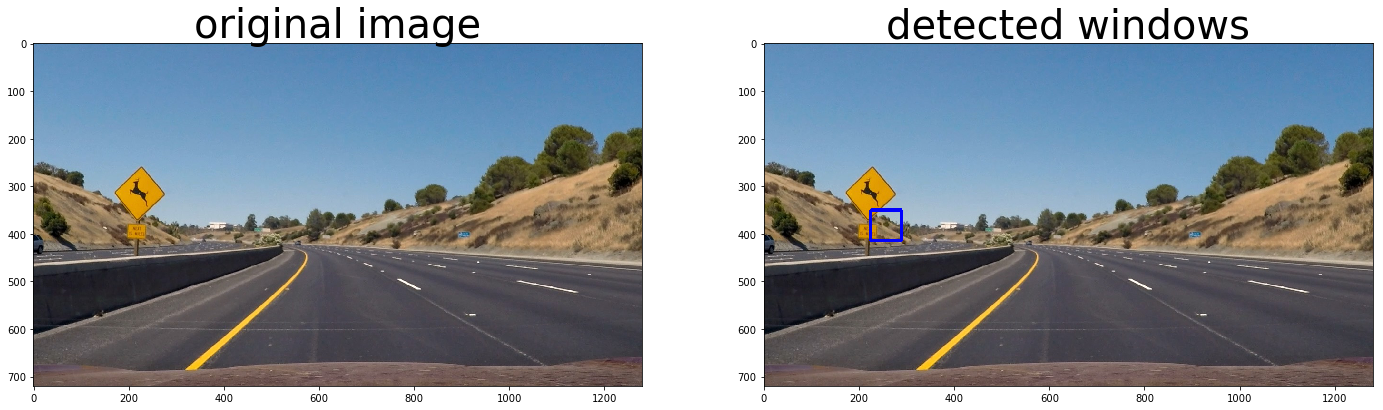

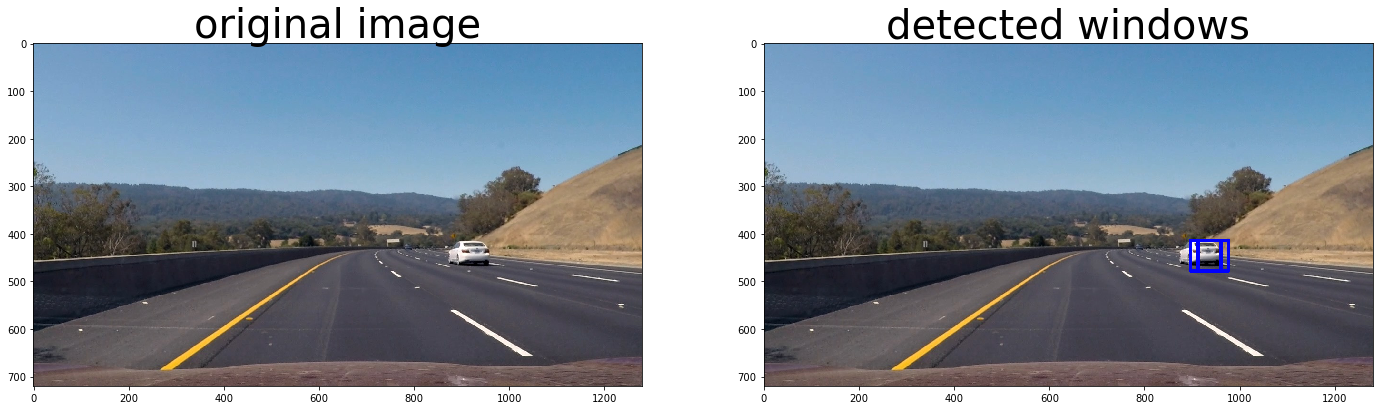

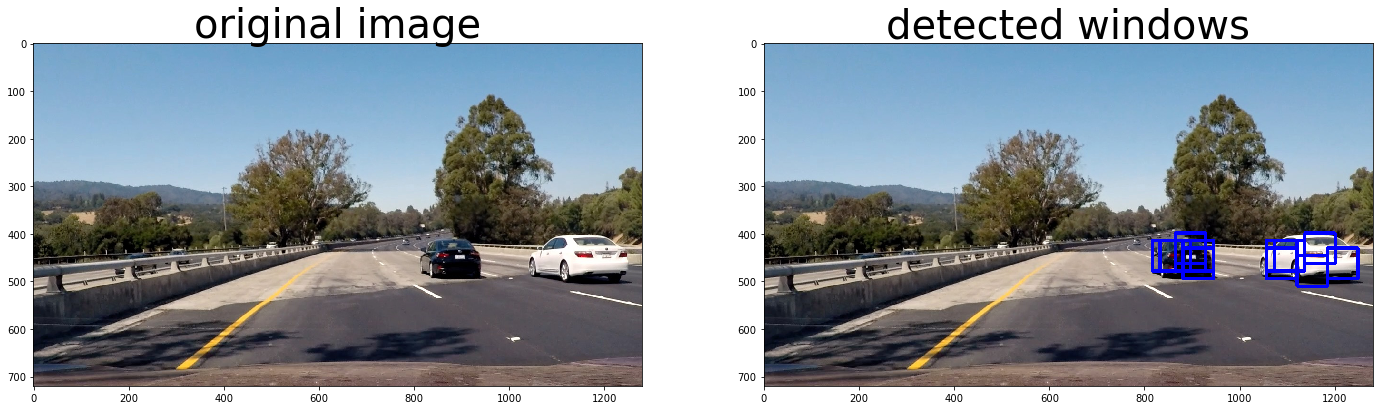

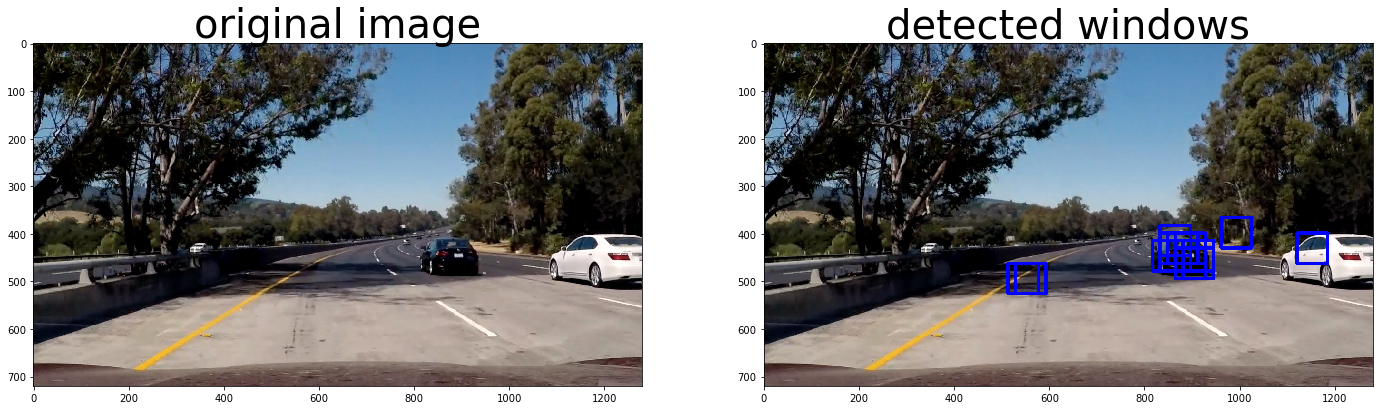

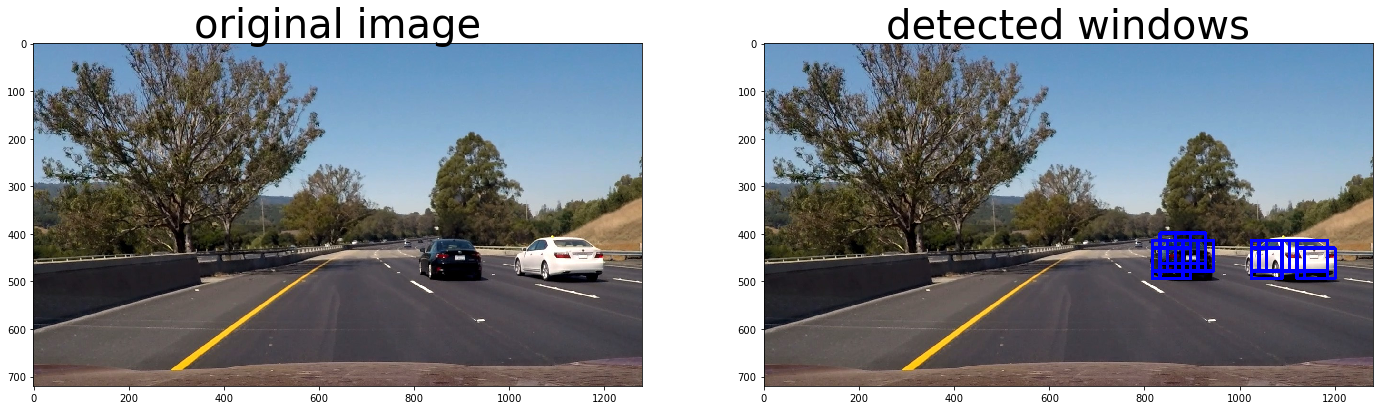

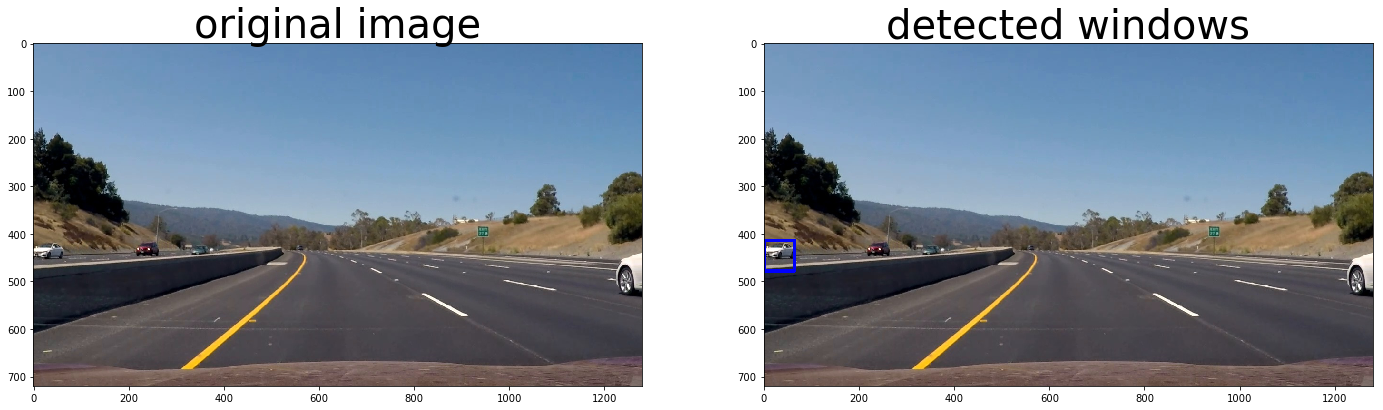

In [14]:
plt.figure(figsize=(20,10))
for i in range(1, 8):
    image = mpimg.imread('test_images/test'+str(i)+'.jpg')
    win_list, img = process_image_no_heatmap(image)
    
        
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
    ax1.imshow(image)
    ax1.set_title('original image', fontsize=40)
    ax2.imshow(img)
    ax2.set_title('detected windows', fontsize=40)
    #plt.subplot(2, 3, i)
    #plt.imshow(draw_img)

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # new code
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        if np.max(heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]]) > 1:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 2

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [16]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [17]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

C:\Anaconda3\envs\CarND-Vehicle-Detection\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


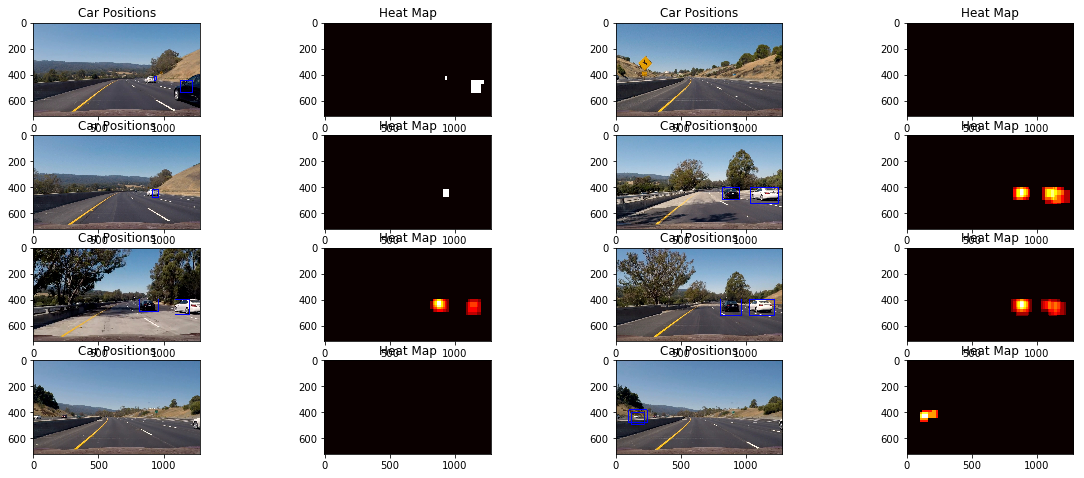

In [18]:
def process_image(image):
    global svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # minimum (32,32)
    # maximum (128,128)
    win_list_all = []
    
    win_list, out_img = find_cars(image, y_start_stop[0], y_start_stop[0]+150, scale, svc, 
                            X_scaler, orient, pix_per_cell, cell_per_block, 
                            spatial_size, hist_bins)
    win_list_all += win_list
    win_list, out_img = find_cars(image, y_start_stop[0]+50, y_start_stop[1], 1.5, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, 
                        spatial_size, hist_bins)
    win_list_all += win_list
    win_list, out_img = find_cars(image, y_start_stop[0]+50, y_start_stop[1], 2.0, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, 
                        spatial_size, hist_bins)
    win_list_all += win_list
    
    # Add heat to each box in box list
    heat = add_heat(heat, win_list_all)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying
    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img, heatmap

plt.figure(figsize=(20,10))
subplot_i = 1
for i in range(1, 9):
    image = mpimg.imread('test_images/test'+str(i)+'.jpg')
    draw_img, heatmap = process_image(image)
    plt.subplot(5,4,subplot_i)
    subplot_i += 1
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(5,4,subplot_i)
    subplot_i += 1
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')

In [19]:
def process_video(image):
    global heatmaps, frame_i
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Save video images
    #video_img = np.copy(image)
    #video_img_BGR = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    #cv2.imwrite('video_images/frame'+str(frame_i)+'.jpg', video_img_BGR)
    
    draw_image = np.copy(image)

    win_list_all = []
    win_list, out_img = find_cars(image, y_start_stop[0], y_start_stop[0]+150, scale, svc, 
                            X_scaler, orient, pix_per_cell, cell_per_block, 
                            spatial_size, hist_bins)
    win_list_all += win_list
    win_list, out_img = find_cars(image, y_start_stop[0]+50, y_start_stop[1], 1.5, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, 
                        spatial_size, hist_bins)
    win_list_all += win_list
    win_list, out_img = find_cars(image, y_start_stop[0]+50, y_start_stop[1], 2.0, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, 
                        spatial_size, hist_bins)
    win_list_all += win_list
    
    if len(win_list_all) > 0:
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat, win_list_all)
        heatmaps.append(heat)
        
        if len(heatmaps) == maxlen:
        # Apply threshold to help remove false positives
            avg_heat = sum(heatmaps)/len(heatmaps)
            heat = avg_heat
        heat = apply_threshold(heat, threshold)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
    else:
        draw_img = draw_image
    img_BGR = cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('test_video_images/frame'+str(frame_i)+'.jpg', img_BGR)
    frame_i += 1
    
    return draw_img

In [20]:
# Test on Videos
# Import everything needed to edit/save/watch video clips
import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
#from IPython.display import HTML

from collections import deque
frame_i = 0
heatmaps = deque(maxlen=maxlen)
video_name = 'project_video'
video_output = 'output_videos/'+video_name+str(time.time())+'.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

clip1 = VideoFileClip(video_name+'.mp4')
#clip1 = clip1.subclip(9,10)
clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video1501760426.0948732.mp4
[MoviePy] Writing video output_videos/project_video1501760426.0948732.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [33:12<00:01,  1.42s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video1501760426.0948732.mp4 

Wall time: 33min 13s
